# Stress Detection Training Model

This notebook trains a machine learning model to detect stress levels based on HRV, Body Temperature Data and can be extended to include other features from the dataset. For training we use the WESAD dataset.

## Importing Libraies

In [3]:
import heartpy as hp
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict, LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Defining Functions

### calculate_hrv

This function takes ecg segments and the smaple rate and returns the hrv data for that segment

In [4]:
def calculate_hrv(ecg_segment, sampling_rate):
    wd, m = hp.process(ecg_segment, sample_rate=sampling_rate)
    return m

### get_subject_data

This function gets the subjects HRV and temperature data with stress labels from the WESAD dataset. It then reduces the multiple labels into binary labels, either stressed or not stressed.

In [8]:
def get_subject_data(sid):
    file = 'WESAD/' + sid + '/' + sid + '.pkl'
    # Load data
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    labels = data['label']  # Extracting the Labels in their own array
    ecg_data = data['signal']['chest']['ECG'][:, 0]  # Extracting the ECG data
    sampling_rate = 700  # The sampling rate for ALL data

    # List to store HRV metrics dictionaries
    hrv_metrics_list = []

    # Define minimum and maximum segment lengths (in data points)
    min_length = sampling_rate * 5  # 5 seconds
    max_length = sampling_rate * 360  # 6 minutes

    # Segment the data by labels
    ignored_labels = [5, 6, 7]  # Ignored labels as declared in dataset
    unique_labels = [label for label in np.unique(labels) if label not in ignored_labels]  # Get all labels
    for label in unique_labels:
        # Find indices where the current label is present
        label_indices = np.where(labels == label)[0]

        # Split the indices into consecutive chunks using np.split
        diff_indices = np.where(np.diff(label_indices) != 1)[0] + 1
        split_indices = np.split(label_indices, diff_indices)

        for segment_indices in split_indices:
            # Split segments further if they exceed the maximum length
            for start_idx in range(0, len(segment_indices), max_length):
                sub_segment_indices = segment_indices[start_idx:start_idx + max_length]

                if len(sub_segment_indices) >= min_length:  # Check if the segment meets the minimum length requirement
                    ecg_segment = ecg_data[sub_segment_indices]  # Segmenting ECG data

                    hrv_metrics = calculate_hrv(ecg_segment, sampling_rate)  # Get HRV for that segment
                    hrv_metrics['Label'] = 0 if label == 2 else 1  # Saves the Label for that segment
                    
                    hrv_metrics_list.append(hrv_metrics)  # Adds metric to the list

    # Create DataFrame from the list of HRV metrics dictionaries
    hrv_data = pd.DataFrame(hrv_metrics_list)
    # Separate labels
    labels = hrv_data['Label']
    # Adjust Features Here
    features = hrv_data[['rmssd','sdnn']]  # Adjusted to only include RMSSD and SDNN
    return features, labels


### train_general_model

Trains the general model when given a set of subject ids.

In [9]:
def train_general_model(sids):
    all_features = []
    all_labels = []

    # Get the data for each subject and append to lists
    for subject_id in sids:
        features, labels = get_subject_data(subject_id)
        all_features.append(features)
        all_labels.append(labels)

    # Concatenate all data
    x = pd.concat(all_features, ignore_index=True)
    y = pd.concat(all_labels, ignore_index=True)

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Initialize SMOTE and resample the dataset
    smote = SMOTE(random_state=42)
    x_resampled, y_resampled = smote.fit_resample(x, y_encoded)
    x_train, X_val, y_train, y_val = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)



    # Initialize the XGBoost model with scale_pos_weight
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
    )

    # Initialize Stratified K-Fold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation predictions
    y_pred = cross_val_predict(model, x_train, y_train, cv=skf)

    # Evaluate the model and print the report
    report = classification_report(y_train, y_pred)
    print(report)
    overall_accuracy = accuracy_score(y_train, y_pred) * 100
    print(f'Overall accuracy: {overall_accuracy:.2f}%')

    # Save the evaluation report to a text file
    with open('evaluation_report_rt.txt', 'w') as f:
        f.write(report)
        f.write(f'Overall accuracy: {overall_accuracy:.2f}%\n')

    # Confusion Matrix
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('regression_confusion_matrix_analog.png')
    plt.show()
    
    # Train the model on the full dataset
    model.fit(x_train, y_train)

    model.save_model('xg.json')

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Evaluate the model and print the report
    report = classification_report(y_val, y_pred)
    print(report)
    overall_accuracy = accuracy_score(y_val, y_pred) * 100
    print(f'Overall accuracy: {overall_accuracy:.2f}%')


    return model


## Main

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       270
           1       0.82      0.80      0.81       246

    accuracy                           0.82       516
   macro avg       0.82      0.82      0.82       516
weighted avg       0.82      0.82      0.82       516

Overall accuracy: 82.36%


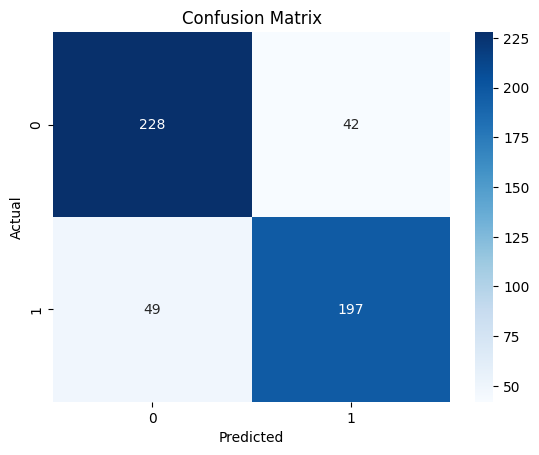

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        53
           1       0.87      0.78      0.82        77

    accuracy                           0.80       130
   macro avg       0.80      0.80      0.80       130
weighted avg       0.81      0.80      0.80       130

Overall accuracy: 80.00%
Model saved successfully.


In [10]:
subject_ids = []
for x in range(18):
    if (x != 0) and (x != 1) and (x!= 12):
        subject = "S" + str(x)
        subject_ids.append(subject)
general_model = train_general_model(subject_ids)
dump(general_model, 'rmssd_model_xg.joblib')
print("Model saved successfully.")